# Korrelation & Zusammenhangsanalyse

In diesem Notebook analysieren wir die Zusammenhänge zwischen verschiedenen Variablen im Taxi-Datensatz. Wir untersuchen:
- Korrelationen zwischen numerischen Variablen
- Zusammenhänge zwischen Fahrtstrecke, Dauer und Kosten
- Zeitliche Muster und deren Einfluss auf andere Variablen

## 1. Daten laden und vorbereiten

In [1]:
# Importieren der benötigten Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import random
import csv
import os

# Einstellungen für bessere Visualisierung
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Größere Plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Bereinigten Datensatz aus Notebook 3 laden
df_clean = pd.read_csv('../data/Taxi_final_1M_clean.csv')

# Zeitvariablen berechnen
df_clean['pickup_datetime'] = pd.to_datetime(df_clean['tpep_pickup_datetime'])
df_clean['pickup_hour'] = df_clean['pickup_datetime'].dt.hour
df_clean['pickup_day_of_week'] = df_clean['pickup_datetime'].dt.dayofweek

print(f"Bereinigter Datensatz geladen: {df_clean.shape[0]:,} Zeilen, {df_clean.shape[1]} Spalten")
print(f"Fehlende Werte: {df_clean.isnull().sum().sum()}")
df_clean.head()

Bereinigter Datensatz geladen: 967,493 Zeilen, 20 Spalten
Fehlende Werte: 0


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,average_speed,pickup_datetime,pickup_hour,pickup_day_of_week
0,2023-02-06 18:31:28,2023-02-06 18:41:28,1.0,2.8,162,113,1,11.4,2.5,2.00,0.0,1.0,19.90,2.5,0.0,10.0,17.0,2023-02-06 18:31:28,18,0
1,2023-01-24 12:53:51,2023-01-24 13:06:09,5.0,2.3,142,48,2,12.1,0.0,0.00,0.0,1.0,16.10,2.5,0.0,12.3,11.2,2023-01-24 12:53:51,12,1
2,2023-02-04 22:58:49,2023-02-04 23:03:11,2.0,1.1,107,107,1,5.8,3.5,1.20,0.0,1.0,12.00,2.5,0.0,4.4,15.5,2023-02-04 22:58:49,22,5
3,2023-02-02 16:39:15,2023-02-02 16:50:39,1.0,2.9,234,249,1,12.1,2.5,3.72,0.0,1.0,22.32,2.5,0.0,11.4,15.5,2023-02-02 16:39:15,16,3
4,2023-02-15 21:08:32,2023-02-15 21:14:12,1.0,1.2,230,48,1,7.2,1.0,2.44,0.0,1.0,14.64,2.5,0.0,5.7,13.1,2023-02-15 21:08:32,21,2


In [ ]:
# Payment Type Mapping
payment_type_map = {
    0: 'Unknown',
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute'
}

df_clean['payment_method'] = df_clean['payment_type'].map(payment_type_map)

Payment Type Mapping:


     payment_type payment_method
72              0        Unknown
0               1    Credit Card
1               2           Cash
587             3      No Charge
54              4        Dispute


## 2. Zahlungsmethode vs. Trinkgeld

Wir untersuchen den Zusammenhang zwischen der Zahlungsmethode und dem Trinkgeld. 
Es gibt folgende Zahlungsmethoden:
- **Credit Card** (1): Kreditkartenzahlung
- **Cash** (2): Barzahlung
- **No Charge** (3): Keine Berechnung
- **Dispute** (4): Streitfall
- **Unknown** (0): Unbekannt

In [7]:
# Trinkgeld-Prozentsatz berechnen (falls noch nicht vorhanden)
df_clean['tip_percentage'] = (df_clean['tip_amount'] / df_clean['fare_amount']) * 100

# Zahlungsmethoden analysieren
payment_types = df_clean.groupby(['payment_type', 'payment_method']).size().reset_index(name='count')
payment_types = payment_types.sort_values('payment_type')

print("Verteilung der Zahlungsmethoden:")
for _, row in payment_types.iterrows():
    percentage = (row['count'] / len(df_clean)) * 100
    print(f"  {row['payment_method']:15s} ({row['payment_type']}): {row['count']:,} ({percentage:.1f}%)")

# Trinkgeld nach Zahlungsmethode
print("\nTrinkgeld-Statistiken nach Zahlungsmethode:")
for payment_type in sorted(df_clean['payment_type'].unique()):
    df_payment = df_clean[df_clean['payment_type'] == payment_type]
    df_payment_with_tip = df_payment[df_payment['tip_amount'] > 0]
    payment_name = df_payment['payment_method'].iloc[0]
    
    avg_tip = df_payment['tip_amount'].mean()
    avg_tip_pct = df_payment_with_tip['tip_percentage'].mean() if len(df_payment_with_tip) > 0 else 0
    trips_with_tip = len(df_payment_with_tip)
    pct_with_tip = (trips_with_tip / len(df_payment)) * 100 if len(df_payment) > 0 else 0
    
    print(f"\n  {payment_name} ({payment_type}):")
    print(f"    Durchschnittliches Trinkgeld: ${avg_tip:.2f}")
    print(f"    Fahrten mit Trinkgeld: {trips_with_tip:,} ({pct_with_tip:.1f}%)")
    if trips_with_tip > 0:
        print(f"    Durchschnittlicher Trinkgeld-Prozentsatz (bei Trinkgeld): {avg_tip_pct:.2f}%")

Verteilung der Zahlungsmethoden:
  Unknown         (0): 26,281 (2.7%)
  Credit Card     (1): 770,412 (79.6%)
  Cash            (2): 161,497 (16.7%)
  No Charge       (3): 3,319 (0.3%)
  Dispute         (4): 5,984 (0.6%)

Trinkgeld-Statistiken nach Zahlungsmethode:

  Unknown (0):
    Durchschnittliches Trinkgeld: $3.54
    Fahrten mit Trinkgeld: 20,346 (77.4%)
    Durchschnittlicher Trinkgeld-Prozentsatz (bei Trinkgeld): 21.59%

  Credit Card (1):
    Durchschnittliches Trinkgeld: $4.38
    Fahrten mit Trinkgeld: 736,151 (95.6%)
    Durchschnittlicher Trinkgeld-Prozentsatz (bei Trinkgeld): 27.20%

  Cash (2):
    Durchschnittliches Trinkgeld: $0.00
    Fahrten mit Trinkgeld: 13 (0.0%)
    Durchschnittlicher Trinkgeld-Prozentsatz (bei Trinkgeld): 32.79%

  No Charge (3):
    Durchschnittliches Trinkgeld: $0.01
    Fahrten mit Trinkgeld: 5 (0.2%)
    Durchschnittlicher Trinkgeld-Prozentsatz (bei Trinkgeld): 30.19%

  Dispute (4):
    Durchschnittliches Trinkgeld: $0.01
    Fahrten mit Tr

**Beobachtungen:**

- Von 161,000 Barzahlungen haben nur 13 Trinkgeld gegeben. Bargeld wird aber direkt an den Fahrer gegeben und erscheint nicht im Zahlungssystem. Wahrscheinlich geben Cash-Zahler ähnlich viel Trinkgeld, es wird nur nicht erfasst

- Nur Kreditkarten-Trinkgelder werden richtig erfasst (95.6% der Credit Card Zahlungen haben Trinkgeld). Über die anderen Payment Types wie Dispute oder Unknown kann man auch keine Aussage treffen.

- Trinkgeld-Analysen sind also nur für Kreditkartenzahlungen aussagekräftig. Wie man es in Amerika kennt wird sehr viel Trinkgeld gegeben, sodass der Durchschnitt bei 27.2% liegt bei denen die Trinkgeld gegeben haben.

## 3. Korrelationsmatrix - Überblick über alle Zusammenhänge

Wir berechnen die Korrelation zwischen allen numerischen Variablen. Der Korrelationskoeffizient misst die Beziehung zwischen zwei Variablen und liegt zwischen -1 und +1:
- +1: Perfekte positive Korrelation
- 0: Keine lineare Korrelation
- -1: Perfekte negative Korrelation

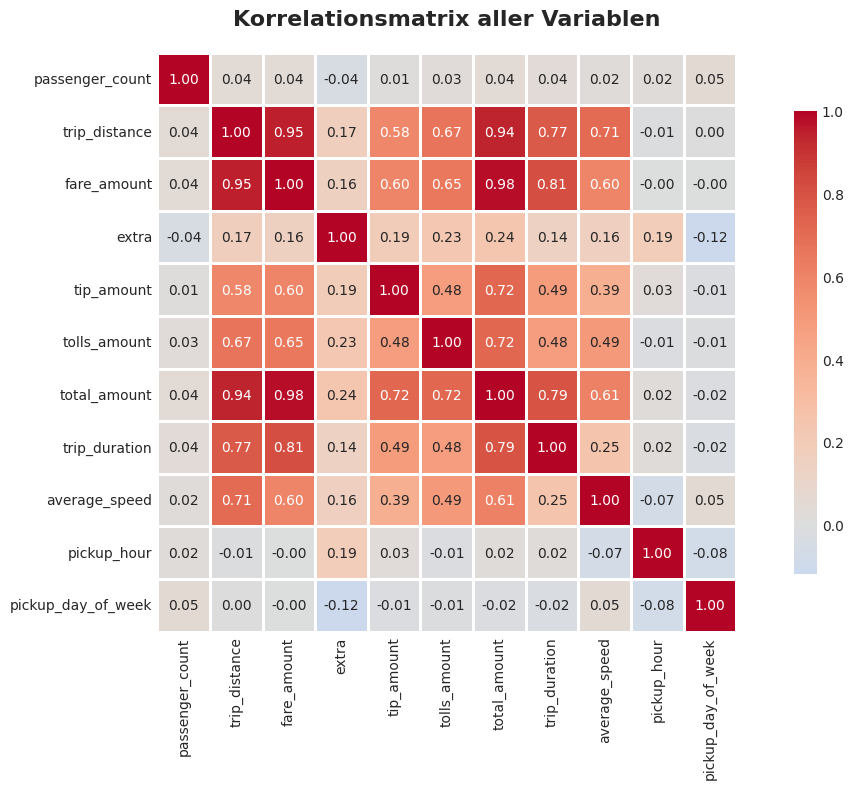

In [8]:
# Auswahl der numerischen Variablen
numerical_cols = ['passenger_count', 'trip_distance', 'fare_amount', 
                  'extra', 'tip_amount', 'tolls_amount', 
                  'total_amount', 'trip_duration', 'average_speed',
                  'pickup_hour', 'pickup_day_of_week']

# Korrelationsmatrix
correlation_matrix = df_clean[numerical_cols].corr()

# Visualisierung der Korrelationsmatrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Korrelationsmatrix aller Variablen', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [11]:
# Die stärksten Korrelationen identifizieren (Diagonale auslassen)
# Korrelationsmatrix zu DataFrame 
corr_pairs = correlation_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs < 1]  # Diagonale entfernen

# Sortieren nach 
strong_correlations = corr_pairs.abs().sort_values(ascending=False).drop_duplicates()

print("Die stärksten Korrelationen:")
for idx, value in strong_correlations.head(10).items():
    print(f"{idx[0]:15s} <-> {idx[1]:15s}: {corr_pairs[idx]:7.3f}")

Die stärksten Korrelationen:
fare_amount     <-> total_amount   :   0.979
fare_amount     <-> trip_distance  :   0.950
total_amount    <-> trip_distance  :   0.941
fare_amount     <-> trip_duration  :   0.813
trip_duration   <-> total_amount   :   0.795
trip_duration   <-> trip_distance  :   0.766
tolls_amount    <-> total_amount   :   0.724
tip_amount      <-> total_amount   :   0.719
average_speed   <-> trip_distance  :   0.711
trip_distance   <-> tolls_amount   :   0.669


## 4. Fahrstrecke und Fahrpreis

Eine der wichtigsten Zusammenhänge ist die Beziehung zwischen der Fahrstrecke (`trip_distance`) und dem Fahrpreis (`fare_amount`). Das soll 1 zu 1 korrelieren.

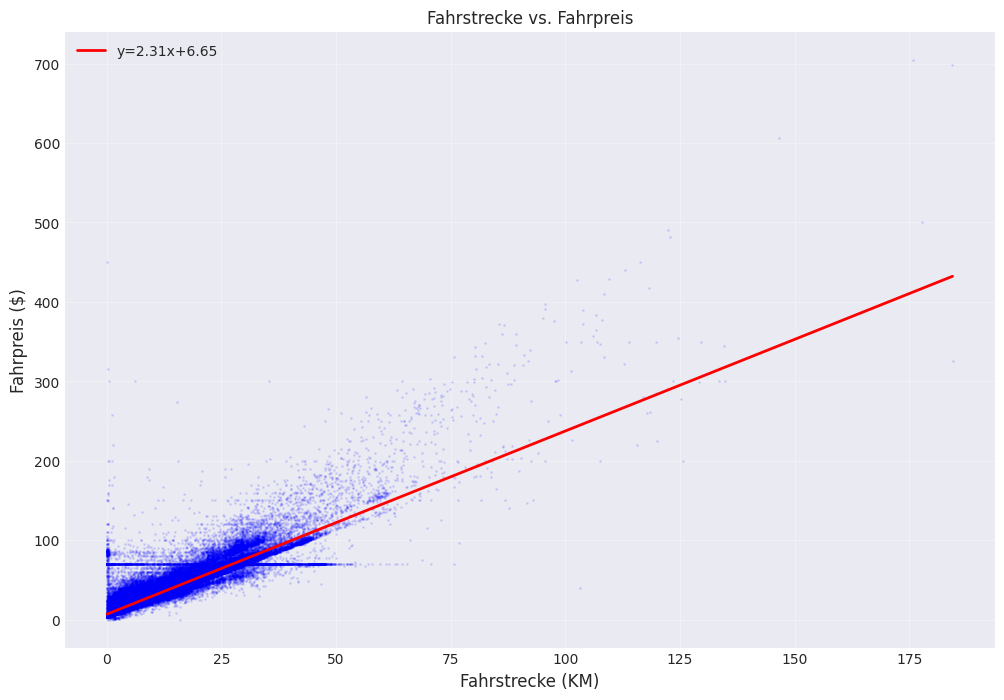

In [ ]:
# Scatterplot: Fahrstrecke vs. Fahrpreis
plt.scatter(df_clean['trip_distance'], df_clean['fare_amount'], 
                alpha=0.1, s=1, c='blue')

# Regressionslinie hinzufügen
z = np.polyfit(df_clean['trip_distance'], df_clean['fare_amount'], 1)
p = np.poly1d(z)
plt.plot(df_clean['trip_distance'].sort_values(), 
             p(df_clean['trip_distance'].sort_values()), 
             "r-", linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')

plt.xlabel('Fahrstrecke (KM)', fontsize=12)
plt.ylabel('Fahrpreis ($)', fontsize=12)
plt.title('Fahrstrecke vs. Fahrpreis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Die Horizontale Linie ist vermutlich eine Basisgebühr bei Pickups vom JFK Airport (bei 70$). Deshalb lassen wir es drin.

## 5. Zusammenhang: Fahrstrecke und Fahrdauer

Fahrstrecke und Fahrdauer sollen logischerweise auch korrelieren, abhängig von der Durchschnittsgeschwindigkeit.

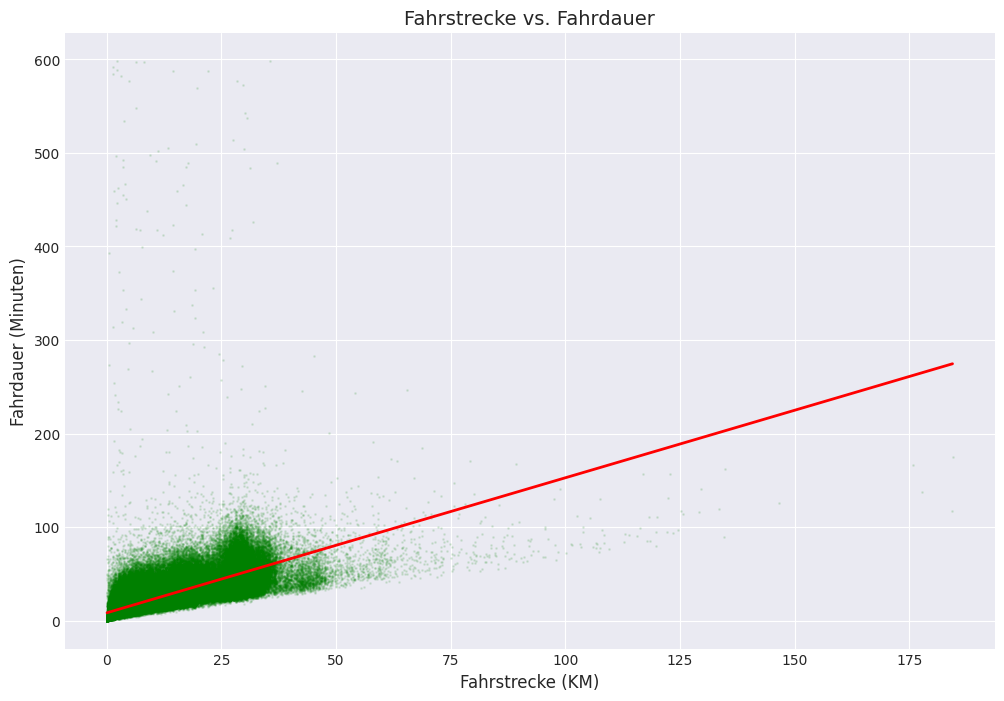


Durchschnittliche Geschwindigkeit aller Fahrten: 18.33 km/h


In [12]:
# Scatterplot: Fahrstrecke vs. Fahrdauer
plt.scatter(df_clean['trip_distance'], df_clean['trip_duration'], 
                alpha=0.1, s=1, c='green')

z = np.polyfit(df_clean['trip_distance'], df_clean['trip_duration'], 1)
p = np.poly1d(z)

plt.plot(df_clean['trip_distance'].sort_values(), 
             p(df_clean['trip_distance'].sort_values()), 
             "r-", linewidth=2)
plt.xlabel('Fahrstrecke (KM)', fontsize=12)
plt.ylabel('Fahrdauer (Minuten)', fontsize=12)
plt.title('Fahrstrecke vs. Fahrdauer', fontsize=14)
plt.show()


# Durchschnittliche Geschwindigkeit
avg_speed_overall = df_clean['average_speed'].mean()
print(f"\nDurchschnittliche Geschwindigkeit aller Fahrten: {avg_speed_overall:.2f} km/h")


## 6. Zusammenhang: Trinkgeld und Fahrpreis

Ein interessanter Zusammenhang ist die Beziehung zwischen dem Trinkgeld (`tip_amount`) und dem Fahrpreis (`fare_amount`). Wir erwarten ein höheres Trinkgeld bei höheren Fahrpreis, da es Konvention ist prozentual Trinkgeld zu geben.

**Wichtig:** Wir analysieren nur **Credit Card Zahlungen**, da nur dort Trinkgelder zuverlässig erfasst werden!

/tmp/ipykernel_798/1135894902.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


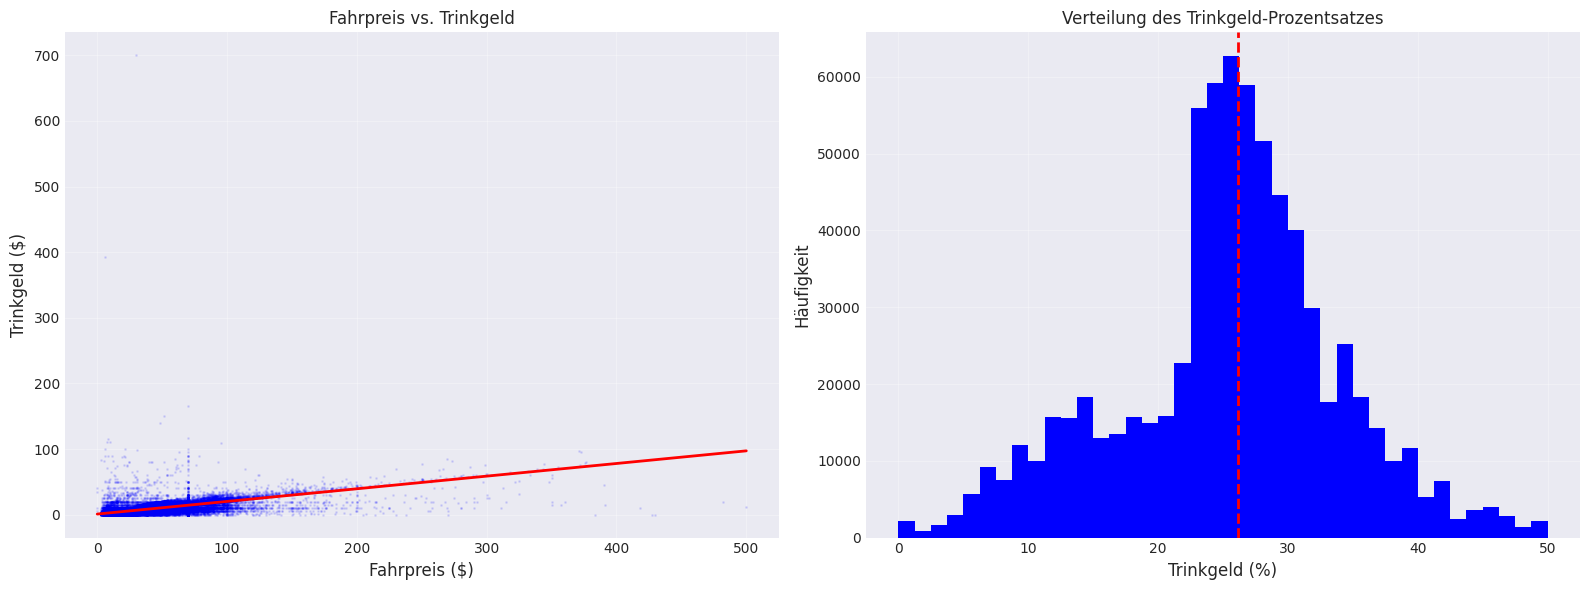

---Trinkgeld Statistiken (nur Credit Card)---
Durchschnittlicher Prozentsatz Trinkgeld: 27.20%
Median Prozentsatz Trinkgeld: 26.17%
Credit Card Fahrten mit Trinkgeld: 736,151
Anteil an allen Credit Card Fahrten: 95.6%


In [ ]:
# Trinkgeld-Prozentsatz berechnen
df_clean['tip_percentage'] = (df_clean['tip_amount'] / df_clean['fare_amount']) * 100

# Nur Credit Card Zahlungen mit Trinkgeld (Payment Type 1)
df_with_tip = df_clean[(df_clean['payment_type'] == 1) & (df_clean['tip_amount'] > 0)].copy()
median_tip_perfentage = df_with_tip["tip_percentage"].median()

# Trinkgeld-Prozentsatz Verteilung Histrogramm
plt.figure(figsize=(10, 6))
df_with_tip[df_with_tip['tip_percentage'] <= 50]['tip_percentage'].hist(
    bins=40, color='blue', edgecolor='white')

plt.xlabel('Trinkgeld (%)', fontsize=12)
plt.ylabel('Häufigkeit', fontsize=12)
plt.title('Verteilung des Trinkgeld-Prozentsatzes (Credit Card)', fontsize=14, fontweight='bold')
plt.axvline(median_tip_perfentage, color='red', 
            linestyle='--', linewidth=2, label=f'Median: {median_tip_perfentage:.1f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("---Trinkgeld Statistiken (nur Credit Card)---")
print(f"Durchschnittlicher Prozentsatz Trinkgeld: {df_with_tip['tip_percentage'].mean():.2f}%")
print(f"Median Prozentsatz Trinkgeld: {df_with_tip['tip_percentage'].median():.2f}%")
print(f"Credit Card Fahrten mit Trinkgeld: {len(df_with_tip):,}")
print(f"Anteil an allen Credit Card Fahrten: {len(df_with_tip)/len(df_clean[df_clean['payment_type']==1])*100:.1f}%")